In [1]:
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16 as PreTrainedModel, preprocess_input
from tensorflow.keras.optimizers import SGD, Adam

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [ ]:
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/kaggle"
# !pwd
# !dir
# %cd drive/My Drive/kaggle
# !dir
# !kaggle datasets download -d binhminhs10/food5k
# #unzipping the zip files and deleting the zip files
# !unzip \*.zip  && rm *.zip

In [2]:
!dir

drive  sample_data


## **`Here all the images starting with 0 are non-food and all the images starting with 1 are food.`**

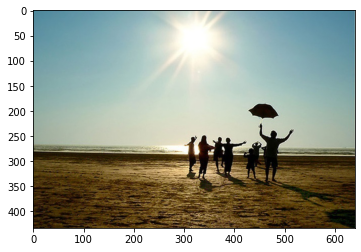

In [ ]:
plt.imshow(image.load_img('drive/My Drive/kaggle/Food-5K/training/0_143.jpg'));

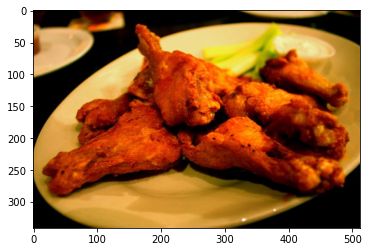

In [ ]:
plt.imshow(image.load_img('drive/My Drive/kaggle/Food-5K/training/1_143.jpg'));

In [ ]:
# Making Directions in "content" directory to store the data in Keras style
!mkdir data
!mkdir data/train
!mkdir data/test
!mkdir data/train/nonfood
!mkdir data/train/food
!mkdir data/test/nonfood
!mkdir data/test/food

In [ ]:
!pwd

/content


In [ ]:
# Moving the images
# We will consider "training" to be the train set and "validation" as the test set and ignore the "evaluation" set

# !mv drive/My\ Drive/kaggle/Food-5K/training/0*.jpg data/train/nonfood
# !mv drive/My\ Drive/kaggle/Food-5K/training/1*.jpg data/train/food
# !mv drive/My\ Drive/kaggle/Food-5K/validation/0*.jpg data/test/nonfood
# !mv drive/My\ Drive/kaggle/Food-5K/validation/1*.jpg data/test/food

In [ ]:
train_path = "data/train"
valid_path = "data/test"

In [ ]:
# These images are pretty big and of different sizes.
# Let's load them in a same smaller size(200*200)
IMG_SIZE = [200, 200]

In [ ]:
# Getting the list of all the train and test image files using the globe function
# this will be useful for determining number of files
image_files = glob(train_path + "/*/*.jpg")
valid_image_files = glob(valid_path + "/*/*.jpg")

In [ ]:
# This will be useful for getting number of classes
folders = glob(train_path + "/*")
folders

['data/train/nonfood', 'data/train/food']

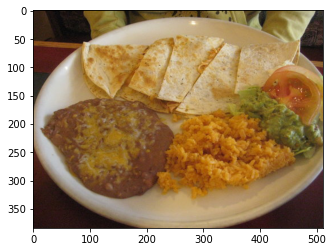

In [ ]:
# Displaying an image for checking
plt.imshow(image.load_img(np.random.choice(image_files)));

In [ ]:
# Creating an instance of the pre trained model
pre_trained_model = PreTrainedModel(input_shape = IMG_SIZE + [3],    # 3 is for the number of color channels
                                    weights = "imagenet",  # The model downloads pretrained weights from VGG16 trained on Imagenet dataset
                                    include_top = False)   # Instead of full VGG network,we just get layers upto final convolution layer
                                                           # There's no Flatten or none of the final Dense Layers

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
# Freeze pre-trained model weights
pre_trained_model.trainable = False # After calling "model.fit" later,the weights will not be changed by Gradiant Descent

In [ ]:
# Creating the "Head" of our neural network

# Map the data into feature vectors
# Keras ImageDataGenerator returns classes one-hot-encoded

K = len(folders)    # number of classes
x = Flatten() (pre_trained_model.output)    # Creating a Flatten Layer and passing the output of the pre-trained model
x = Dense(K, activation="softmax") (x)

In [ ]:
# Creating the model
model = Model(inputs = pre_trained_model.input, outputs = x)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)      

In [ ]:
# Creating an instance of ImageDatagGenerator
gen = ImageDataGenerator(     # The arguments are changed for the purpose of image augmentation
                         rotation_range = 20, 
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         shear_range = 0.1,
                         zoom_range = 0.2,
                         horizontal_flip = True,
                         preprocessing_function = preprocess_input # the generator will transform the images into an appropriate format
                        )

In [ ]:
batch_size = 128

In [ ]:
# Creating actual generators using the ImageDataGenerator object
train_generator = gen.flow_from_directory(train_path,
                                          target_size = IMG_SIZE,
                                          batch_size = batch_size,
                                          shuffle = True)

valid_generator = gen.flow_from_directory(valid_path,
                                          target_size = IMG_SIZE,
                                          batch_size = batch_size)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
# Compile the model
model.compile(optimizer="adam", 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])

In [ ]:
# Fit the model
r = model.fit_generator(train_generator, validation_data=valid_generator,
                        epochs = 10,
                        steps_per_epoch = int(np.ceil(len(image_files) / batch_size)),
                        validation_steps = int(np.ceil(len(valid_image_files) / batch_size))
                        )

Epoch 1/10
24/24 [==============================] - 1576s 66s/step - loss: 1.2220 - accuracy: 0.9460 - val_loss: 1.1017 - val_accuracy: 0.9650
Epoch 2/10
24/24 [==============================] - 1567s 65s/step - loss: 0.4306 - accuracy: 0.9763 - val_loss: 1.1636 - val_accuracy: 0.9620
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 0.2062 - accuracy: 0.9870 